In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('step1_output.csv')
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172414 entries, 0 to 172413
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   favorite_count             172414 non-null  int64  
 1   tweet_id                   172414 non-null  int64  
 2   text                       172414 non-null  object 
 3   in_reply_to_status_id_str  25743 non-null   float64
 4   in_reply_to_user_id_str    29434 non-null   float64
 5   in_reply_to_screen_name    29427 non-null   object 
 6   is_quote_status            172414 non-null  int64  
 7   country_code               172414 non-null  int64  
 8   possibly_sensitive         140392 non-null  object 
 9   quoted_status_id_str       43736 non-null   float64
 10  retweet_count              172414 non-null  int64  
 11  user_id                    172414 non-null  int64  
 12  name                       172399 non-null  object 
 13  screen_name                17

In [4]:
df = df.drop(['tweet_id', 'user_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'quoted_status_id_str', 'text', 'in_reply_to_screen_name', 'name', 'screen_name', 'location', 'description'], axis=1)

In [5]:
cat_cols_1 = ['possibly_sensitive']

poss_sens_le = LabelEncoder()
poss_sens_col_encoded = poss_sens_le.fit_transform(df[cat_cols_1[0]])
df[cat_cols_1[0]] = poss_sens_col_encoded

In [6]:
df

,favorite_count,is_quote_status,country_code,possibly_sensitive,retweet_count,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day,hashtag_count,urls_count,user_mentions_count
0,0,0,111,0,0,0,125,141,0,44,272830,0,0,4,5,20,1,55,17,7,2012,31,1,0,1,0
1,0,0,111,0,0,0,439,480,0,14753,12736,1,0,4,5,20,1,23,15,11,2020,7,1,0,1,0
2,0,1,111,0,1,0,80,57,0,1636,448,1,0,4,5,20,1,9,13,3,2014,10,1,0,1,0
3,0,0,111,2,0,0,119,76,12,12,6786,1,0,4,5,20,1,31,16,3,2010,24,1,0,1,0
4,0,0,111,0,0,0,26889,13732,1268,2658,649692,0,0,5,5,20,1,44,8,6,2009,13,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172409,1,0,111,0,0,0,777,11,6,1,4464,1,0,4,5,21,0,51,21,7,2020,31,0,0,1,0
172410,1,0,111,2,0,0,106,228,0,9848,10456,1,0,4,5,21,0,28,0,8,2020,13,0,0,1,0
172411,0,0,111,0,0,0,1,0,0,0,30784,1,0,4,5,21,0,21,15,11,2020,30,0,0,1,0
172412,1,0,111,2,0,0,188,412,1,5632,8431,0,0,4,5,21,0,20,22,5,2011,24,0,0,1,0


# Feature Correlation Analysis

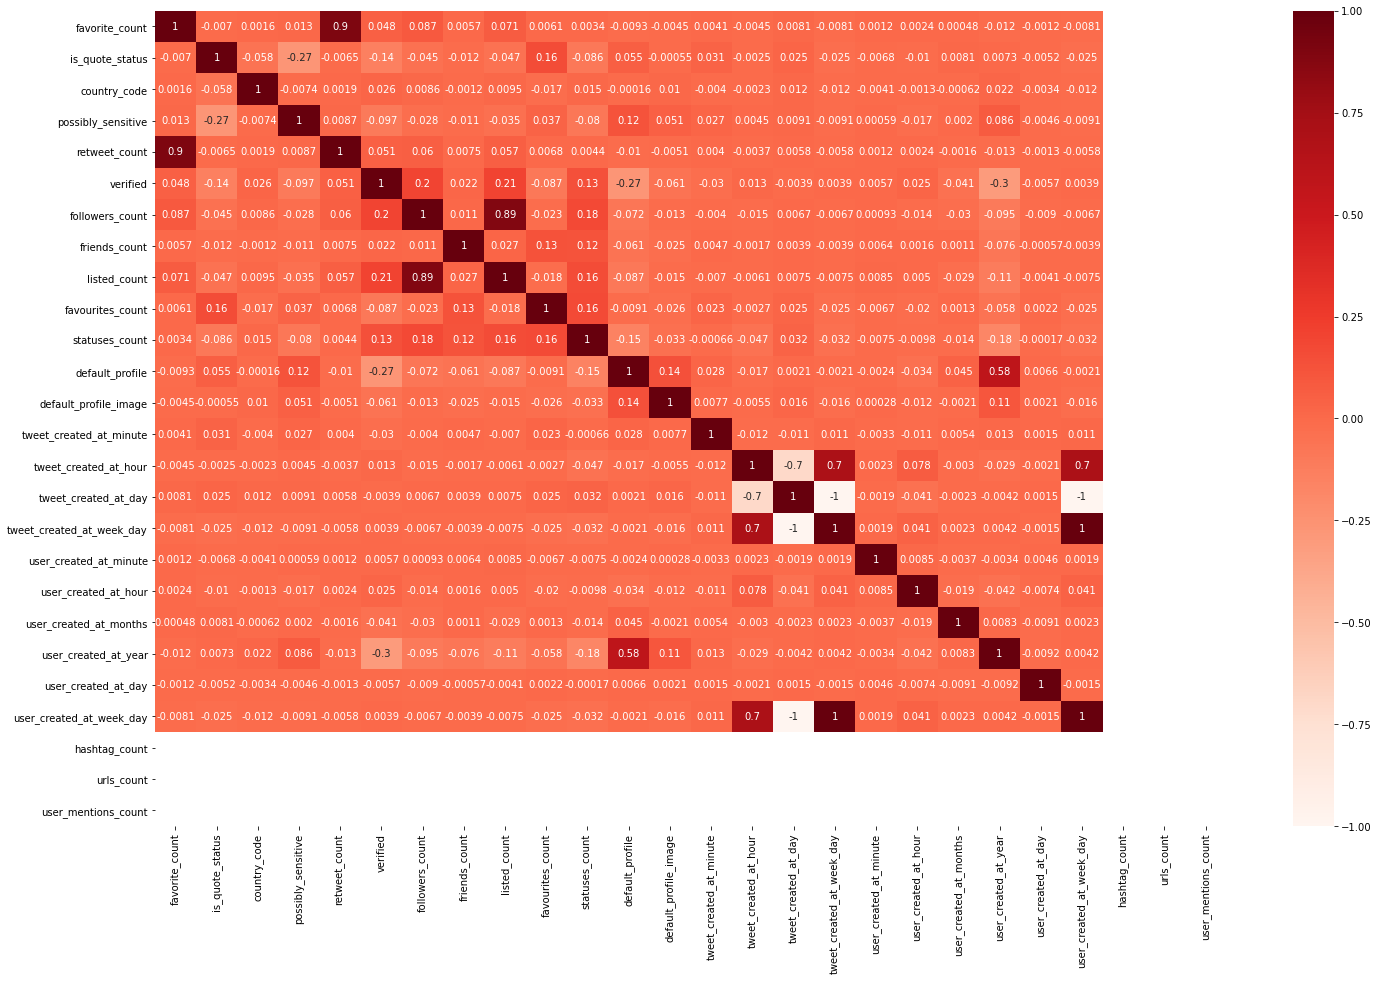

In [10]:
#Using Pearson Correlation
plt.figure(figsize=(24,15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
#Correlation with output variable
cor_target = abs(cor["retweet_count"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

favorite_count    0.903069
retweet_count     1.000000
Name: retweet_count, dtype: float64

In [14]:
# Shuffle the Dataset.
shuffled_train = df.sample(frac=1, random_state=4)

# Put all the samples where they dont have zeros re-tweet in a separate dataset.
non_zero_retweet = shuffled_train.loc[shuffled_train['retweet_count'] != 0]
nbr_samples = non_zero_retweet.shape[0] // 2

#Randomly select samples observations from the zero re-tweet (majority class)
zero_retweet = shuffled_train.loc[shuffled_train['retweet_count'] == 0].sample(n=nbr_samples, random_state=42)

print("Shape of non_zero_retweet: ", non_zero_retweet[:nbr_samples].shape)
print("Shape of zero_retweet: ", zero_retweet.shape)

# Concatenate both dataframes again
train_data = pd.concat([non_zero_retweet[:nbr_samples], zero_retweet])
#train_data_new = non_zero_retweet
print("Normalized train dataset: ", train_data.shape)

# train_data = df
# print("Normalized train dataset: ", train_data.shape)

Shape of non_zero_retweet:  (22431, 26)
Shape of zero_retweet:  (22431, 26)
Normalized train dataset:  (44862, 26)


In [15]:
train_data

,favorite_count,is_quote_status,country_code,possibly_sensitive,retweet_count,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,default_profile,default_profile_image,tweet_created_at_minute,tweet_created_at_hour,tweet_created_at_day,tweet_created_at_week_day,user_created_at_minute,user_created_at_hour,user_created_at_months,user_created_at_year,user_created_at_day,user_created_at_week_day,hashtag_count,urls_count,user_mentions_count
108462,4,0,111,0,1,0,160,144,0,157,352,0,0,6,19,20,1,21,13,10,2018,15,1,0,1,0
93481,4,0,111,2,1,0,10822,10912,288,30453,65286,0,0,24,17,20,1,28,14,7,2007,25,1,0,1,0
67732,16,0,111,0,1,0,282069,2241,1355,2726,158383,0,0,52,14,20,1,46,0,6,2010,8,1,0,1,0
120237,2,0,111,0,1,1,144057,472,4200,15,202030,0,0,35,20,20,1,43,8,10,2008,29,1,0,1,0
103322,0,0,111,2,1,0,46,91,0,7,19,1,0,29,18,20,1,15,12,7,2009,12,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60602,0,0,111,0,0,0,65,168,0,607,7635,1,0,6,14,20,1,6,18,1,2019,2,1,0,1,0
120267,0,0,111,0,0,0,864,1184,4,523,1870,1,0,35,20,20,1,55,5,10,2015,20,1,0,1,0
131634,0,0,111,0,0,0,1487,2628,148,78430,130677,0,0,1,22,20,1,59,22,1,2008,16,1,0,1,0
47244,0,0,111,0,0,0,210,9,14,0,57143,1,1,40,12,20,1,18,7,8,2013,28,1,0,1,0


In [16]:
y_train = train_data['retweet_count']
y_train[y_train > 0] = 1
X_train = train_data.drop(['retweet_count'], axis=1)

C:\Users\ALike\AppData\Local\Temp/ipykernel_5980/141878633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train > 0] = 1


In [17]:
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))

(44862, 25)
(44862,)
[0 1]


https://scikit-learn.org/stable/supervised_learning.html

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [20]:
print(X_train.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(44862, 25)
(33646, 25)
(11216, 25)
(33646,)
(11216,)


# Train a logistic regression model

In [12]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=10000)
logisticRegr.fit(x_train, y_train)
predictions_LR = logisticRegr.predict(x_test)

Hyper Parameter Tuning:

In [13]:
# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

# elastic_net_parametersGrid = dict()
# elastic_net_parametersGrid['alpha'] = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10]
# elastic_net_parametersGrid['l1_ratio'] = np.arange(0.0, 1.0, 0.5)

# search_elasticNet = GridSearchCV(logisticRegr, elastic_net_parametersGrid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# results_elasticNet = search_elasticNet.fit(x_train, y_train)

# print('ELASTICNET MAE: %.3f' % results_elasticNet.best_score_)
# print('ELASTICNET Config: %s' % results_elasticNet.best_params_)

In [14]:
# Use score method to get accuracy of model
score_LR = logisticRegr.score(x_test, y_test)
print(score_LR)
cm_LR = metrics.confusion_matrix(y_test, predictions_LR)
print(cm_LR)

0.7866440798858774
[[5095  503]
 [1890 3728]]


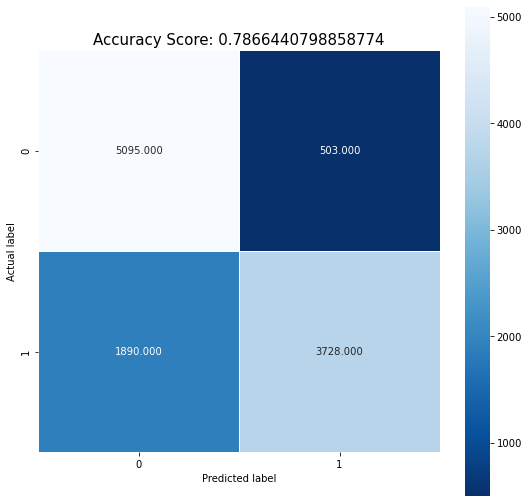

In [15]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_LR, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_LR)
plt.title(all_sample_title, size = 15);

In [16]:
print("Recall: ", recall_score(y_test, predictions_LR))
print("Precision: ", precision_score(y_test, predictions_LR))
print("F1_Score", f1_score(y_test, predictions_LR))

Recall:  0.6635813456746174
Precision:  0.8811155755140628
F1_Score 0.7570311706772263


# Train a Decision tree
https://scikit-learn.org/stable/modules/tree.html#tree

In [17]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
predictions_decisionTree = dt.predict(x_test)

In [18]:
# Use score method to get accuracy of model
score_DT = dt.score(x_test, y_test)
print(score_DT)
cm_DT = metrics.confusion_matrix(y_test, predictions_decisionTree)
print(cm_DT)

0.7522289586305279
[[4245 1353]
 [1426 4192]]


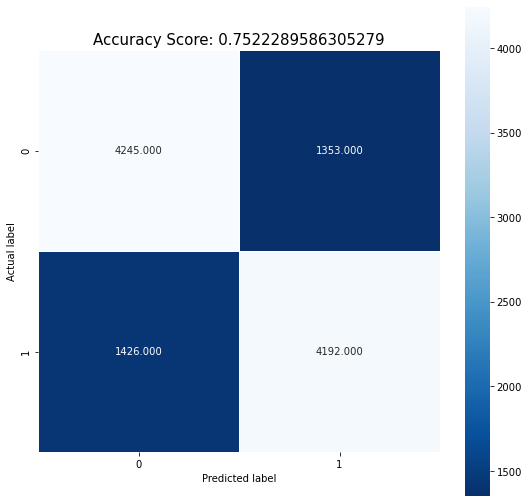

In [19]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_DT, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_DT)
plt.title(all_sample_title, size = 15);

In [20]:
print("Recall: ", recall_score(y_test, predictions_decisionTree))
print("Precision: ", precision_score(y_test, predictions_decisionTree))
print("F1_Score", f1_score(y_test, predictions_decisionTree))

Recall:  0.7461730153079388
Precision:  0.7559963931469793
F1_Score 0.7510525844307085


In [21]:
# uncomment for tree visualization
# from sklearn.tree import plot_tree
# plt.figure(figsize=(6,6))
# plot_tree(dt);

[4.37027726e-01 5.73089834e-03 2.69399856e-03 9.04973547e-03
 2.99151467e-03 7.77801529e-02 4.79272612e-02 4.07614664e-02
 5.94433586e-02 5.78635612e-02 4.23425095e-03 4.12145606e-04
 5.29108323e-02 3.40928638e-02 1.92858589e-03 1.80126456e-03
 3.92710004e-02 3.12046783e-02 2.82398429e-02 2.47153905e-02
 3.89370427e-02 9.82429107e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


<BarContainer object of 25 artists>

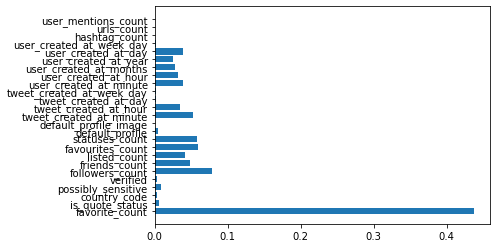

In [22]:
print(dt.feature_importances_)
plt.barh(X_train.columns, dt.feature_importances_)

# Train a RandomForest
https://en.wikipedia.org/wiki/Random_forest

In [23]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
predictions_randomForest = rf.predict(x_test)

In [24]:
# Use score method to get accuracy of model
score_RF = rf.score(x_test, y_test)
print(score_RF)
cm_RF = metrics.confusion_matrix(y_test, predictions_randomForest)
print(cm_RF)

0.8205242510699001
[[4657  941]
 [1072 4546]]


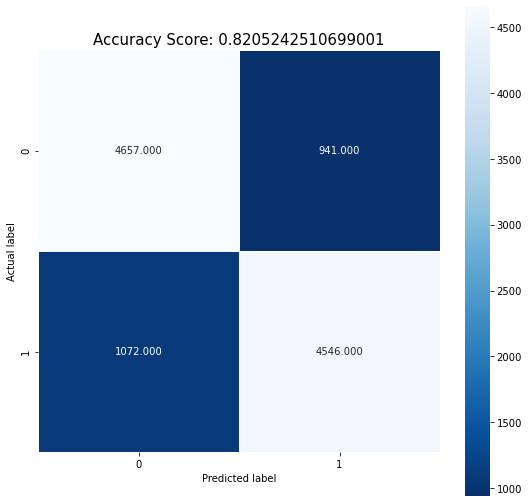

In [25]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_RF, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_RF)
plt.title(all_sample_title, size = 15);

In [26]:
print("Recall: ", recall_score(y_test, predictions_randomForest))
print("Precision: ", precision_score(y_test, predictions_randomForest))
print("F1_Score", f1_score(y_test, predictions_randomForest))

Recall:  0.8091847632609469
Precision:  0.8285037361035174
F1_Score 0.8187303016659162


[0.31451287 0.00604798 0.00319732 0.00854735 0.02361431 0.11782457
 0.05457835 0.07824081 0.0582963  0.05908473 0.00879825 0.00147321
 0.04597551 0.03664657 0.00248959 0.00243292 0.04176328 0.03591876
 0.02962827 0.03014103 0.03841399 0.00237404 0.         0.
 0.        ]


<BarContainer object of 25 artists>

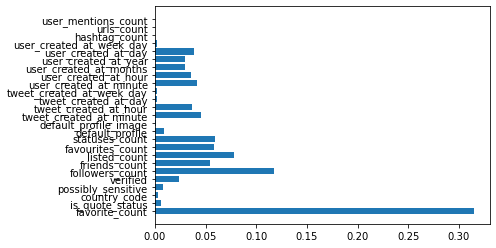

In [27]:
print(rf.feature_importances_)
plt.barh(X_train.columns, rf.feature_importances_)

# Train a XGBoost

In [28]:
import xgboost as xgb
xg = xgb.XGBClassifier(n_estimators=100)
xg.fit(x_train, y_train)
predictions_XGB = xg.predict(x_test)

C:\Users\ALike\.conda\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
# Use score method to get accuracy of model
score_xgb = rf.score(x_test, y_test)
print(score_xgb)
cm_xgb = metrics.confusion_matrix(y_test, predictions_XGB)
print(cm_xgb)

0.8205242510699001
[[4657  941]
 [1124 4494]]


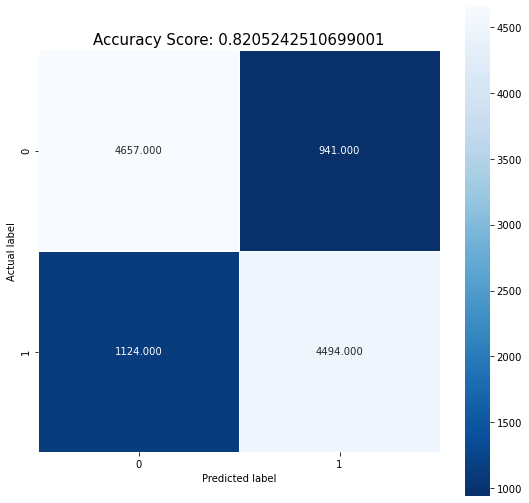

In [30]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_xgb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_xgb)
plt.title(all_sample_title, size = 15);

In [31]:
print("Recall: ", recall_score(y_test, predictions_XGB))
print("Precision: ", precision_score(y_test, predictions_XGB))
print("F1_Score", f1_score(y_test, predictions_XGB))

Recall:  0.7999288002847988
Precision:  0.8268629254829807
F1_Score 0.8131728942368588


[0.65047354 0.02624361 0.01580716 0.03535912 0.02862004 0.03300636
 0.01540245 0.02042054 0.01750706 0.017181   0.01595591 0.01378481
 0.01279215 0.01201626 0.01499927 0.         0.0130698  0.01257969
 0.01377695 0.0173801  0.01362423 0.         0.         0.
 0.        ]


<BarContainer object of 25 artists>

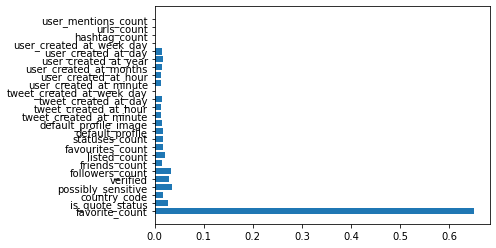

In [32]:
print(xg.feature_importances_)
plt.barh(X_train.columns, xg.feature_importances_)

# XGBoost Customizaed

In [33]:
params = {
    "n_estimators": 25, #number of trees (i.e. iterations)
    "max_depth": 8, # Maximum depth of built trees
    "min_child_weight" : 0, # Minimum sum of instance weight(hessian) needed in a child.
    "subsample": 1.0, # Subsample ratio of the training instance.
    "colsample_bytree" : 1.0 # Subsample ratio of columns when constructing each tree.
}

xg = xgb.XGBClassifier(**params)
xg.fit(x_train, y_train)
predictions_XGB = xg.predict(x_test)

[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\ALike\.conda\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [34]:
# Use score method to get accuracy of model
score_xgb = rf.score(x_test, y_test)
print(score_xgb)
cm_xgb = metrics.confusion_matrix(y_test, predictions_XGB)
print(cm_xgb)

0.8205242510699001
[[4687  911]
 [1135 4483]]


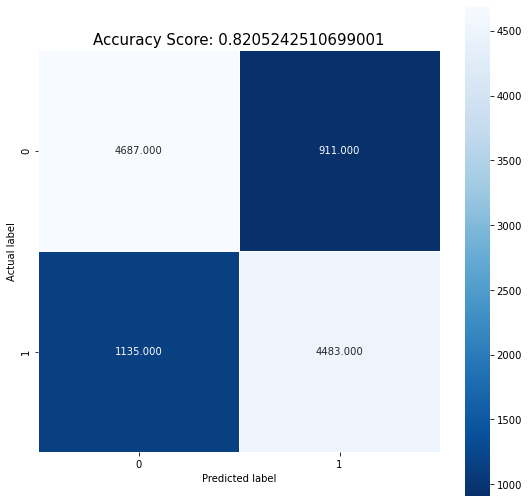

In [35]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_xgb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_xgb)
plt.title(all_sample_title, size = 15);

In [36]:
print("Recall: ", recall_score(y_test, predictions_XGB))
print("Precision: ", precision_score(y_test, predictions_XGB))
print("F1_Score", f1_score(y_test, predictions_XGB))

Recall:  0.7979708081167676
Precision:  0.8311086392287728
F1_Score 0.8142026879767527


# Support Vector Machines

In [37]:
from sklearn import svm
clf_lin = svm.SVC(kernel='linear', max_iter=1000)
clf_lin.fit(x_train, y_train)
predictions_SVM_lin = clf_lin.predict(x_test)

C:\Users\ALike\.conda\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [38]:
# Use score method to get accuracy of model
score_SVM_lin = clf_lin.score(x_test, y_test)
print(score_SVM_lin)
cm_SVM_lin = metrics.confusion_matrix(y_test, predictions_SVM_lin)
print(cm_SVM_lin)

print("Recall: ", recall_score(y_test, predictions_SVM_lin))
print("Precision: ", precision_score(y_test, predictions_SVM_lin))
print("F1_Score", f1_score(y_test, predictions_SVM_lin))

0.5170292439372325
[[5595    3]
 [5414  204]]
Recall:  0.03631185475258099
Precision:  0.9855072463768116
F1_Score 0.07004291845493561


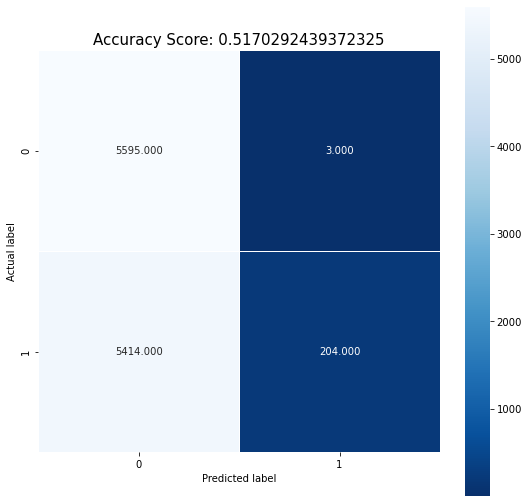

In [39]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_SVM_lin, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_SVM_lin)
plt.title(all_sample_title, size = 15);

rbf kernel:

In [40]:
from sklearn import svm
clf_rbf = svm.SVC(kernel='rbf', max_iter=1000)
clf_rbf.fit(x_train, y_train)
predictions_SVM_rbf = clf_rbf.predict(x_test)

C:\Users\ALike\.conda\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [41]:
# Use score method to get accuracy of model
score_SVM_rbf = clf_rbf.score(x_test, y_test)
print(score_SVM_rbf)
cm_SVM_rbf = metrics.confusion_matrix(y_test, predictions_SVM_rbf)
print(cm_SVM_rbf)

print("Recall: ", recall_score(y_test, predictions_SVM_rbf))
print("Precision: ", precision_score(y_test, predictions_SVM_rbf))
print("F1_Score", f1_score(y_test, predictions_SVM_rbf))

0.4810984308131241
[[  25 5573]
 [ 247 5371]]
Recall:  0.9560341758632965
Precision:  0.49077119883040937
F1_Score 0.6485931650766815


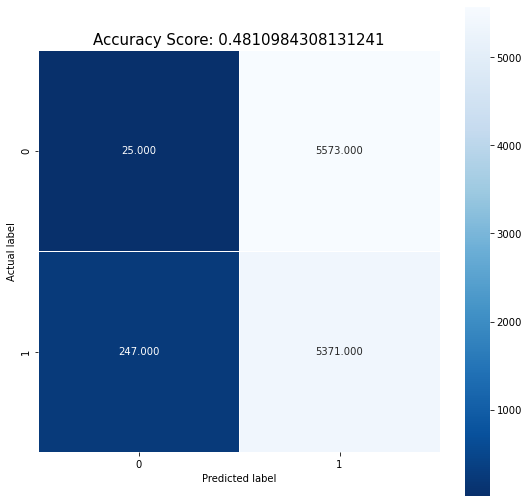

In [42]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_SVM_rbf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_SVM_rbf)
plt.title(all_sample_title, size = 15);

Polynomial kernel:

In [43]:
from sklearn import svm
clf_poly = svm.SVC(kernel='poly', max_iter=1000)
clf_poly.fit(x_train, y_train)
predictions_SVM_poly = clf_poly.predict(x_test)

C:\Users\ALike\.conda\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [44]:
# Use score method to get accuracy of model
score_SVM_poly = clf_poly.score(x_test, y_test)
print(score_SVM_poly)
cm_SVM_poly = metrics.confusion_matrix(y_test, predictions_SVM_poly)
print(cm_SVM_poly)

print("Recall: ", recall_score(y_test, predictions_SVM_poly))
print("Precision: ", precision_score(y_test, predictions_SVM_poly))
print("F1_Score", f1_score(y_test, predictions_SVM_poly))

0.49821683309557774
[[   0 5598]
 [  30 5588]]
Recall:  0.9946600213599146
Precision:  0.49955301269443947
F1_Score 0.6650797429183528


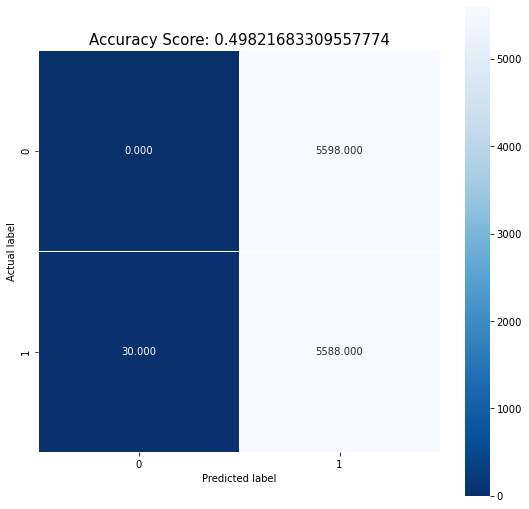

In [45]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_SVM_poly, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_SVM_poly)
plt.title(all_sample_title, size = 15);

# Non-Linear Support Vector Machine
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-auto-examples-svm-plot-svm-nonlinear-py

In [46]:
# from sklearn import svm
# clf_non_linear = svm.NuSVC(gamma="auto")
# clf_non_linear.fit(x_train, y_train)
# predictions_SVM_non_linear = clf_non_linear.predict(x_test)

In [47]:
# # Use score method to get accuracy of model
# score_SVM_non_linear = clf_non_linear.score(x_test, y_test)
# print(score_SVM_non_linear)
# cm_SVM_non_linear = metrics.confusion_matrix(y_test, predictions_SVM)
# print(cm_SVM_non_linear)

In [48]:
# plt.figure(figsize=(9,9))
# sns.heatmap(cm_SVM_non_linear, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
# plt.ylabel('Actual label');
# plt.xlabel('Predicted label');
# all_sample_title = 'Accuracy Score: {0}'.format(score_SVM_non_linear)
# plt.title(all_sample_title, size = 15);

In [49]:
# print("Recall: ", recall_score(y_test, predictions_SVM_non_linear))
# print("Precision: ", precision_score(y_test, predictions_SVM_non_linear))
# print("F1_Score", f1_score(y_test, predictions_SVM_non_linear, average="micro"))

# Neural Network

In [58]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)
x_scaled_train = scaler.transform(x_train)
x_scaled_test = scaler.transform(x_test)

In [59]:
clf_nn = MLPClassifier(random_state=1, max_iter=300).fit(x_scaled_train, y_train)
# neuralnet_predictions = clf_nn.predict_proba(X_test[:1])
predictions_nn = clf_nn.predict(x_scaled_test)

In [60]:
# Use score method to get accuracy of model
score_nn = clf_nn.score(x_scaled_test, y_test)
print(score_nn)
cm_nn = metrics.confusion_matrix(y_test, predictions_nn)
print(cm_nn)

0.7804029957203994
[[4714  884]
 [1579 4039]]


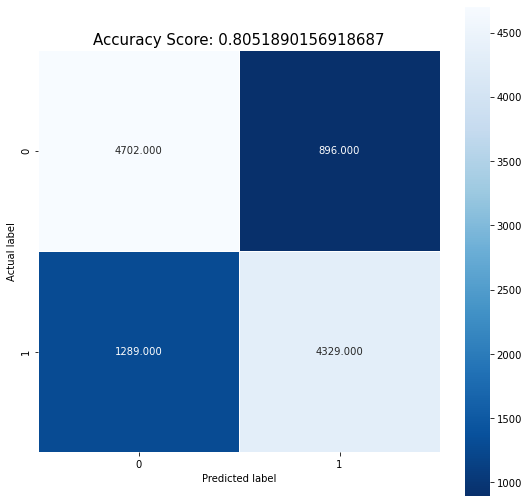

In [53]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_nn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_nn)
plt.title(all_sample_title, size = 15);

In [54]:
print("Recall: ", recall_score(y_test, predictions_nn))
print("Precision: ", precision_score(y_test, predictions_nn))
print("F1_Score", f1_score(y_test, predictions_nn))

Recall:  0.7705589177643289
Precision:  0.8285167464114832
F1_Score 0.7984875034584524
